<a href="https://colab.research.google.com/github/SergeyHSE/LinearRegressor.github.io/blob/main/RegressionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Analysis of descriptive statistics
2. Estimating a regression model under the assumptions of a classical linear regression model (CLRM)
3. Estimation of regression model under deviations from CERM assumptions:
 - Diagnosis of single atypical observations
 - Diagnosis of sample homogeneity
 - Diagnostics of specification errors and model correction when they are detected
 - Diagnosis of multicollinearity and model correction when it is detected
 - Diagnosis of heteroscedasticity and model correction when it is detected
 - Diagnosis of endogeneity and model correction when it is detected


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats

When studying the literature on this topic, the most interesting articles were "Economic efficiency of beef cattle production in Thailand" by Professor Suneeporn Suwanmaneepong of King Mongkut's Institute of Technology Ladkrabang Faculty of Agricultural Technology PhD and "Assessment of technical efficiency and its determinants in beef cattle production in Kenya" by Eric Ruto of Lincoln University. In this paper, the professor describes the economic efficiency of livestock production. To build the model she uses the following variables as the most efficient ones: cost of feed and additives, equipment, drugs and labor, access to priority markets, etc. Unfortunately, our data do not contain information on the costs of purchasing veterinary drugs, so we will not be able to analyze their impact on the profitability of the enterprise. Therefore, we will do something else: we will deduct from the cost price all the cost items that we have. This will give us the amount including the costs of veterinary drugs.

Moreover, both authors conclude in the conclusions of their studies that there is a need for government intervention with different types of assistance such as:
- Improving farmers' access to the knowledge they need to develop their farms as well as their farming skills
- Providing access to more modern technologies
- Improving access to market services
- Creating opportunities for off-farm income generation.

All these factors are in one way or another related to government support, to a certain type of subsidy, which directly, according to the authors, should improve profit margins, and therefore improve the model's performance.


In [2]:
from google.colab import files
file = files.upload()

Saving agro_census.dta to agro_census.dta


In [3]:
data = pd.read_stata('agro_census.dta')
data.columns, data.shape

(Index(['NPPP', 'COD_COATO', 'KFS', 'KOPF', 'OKVED', 'land_total',
        'cost_milk_KRS', 'cost_KRS_food', 'cost_meat_KRS', 'AB_1', 'CF_1',
        'short_credit', 'long_credit', 'debit_debt', 'credit_debt',
        'gov_sup_plant', 'gov_sup_seed', 'gov_sup_grain', 'subs_plant',
        'subs_grain', 'gov_sup_farming', 'gov_sup_KRS', 'subs_prod_farm',
        'subs_milk', 'subs_meat', 'subs_KRS', 'subs_combikorm', 'sub_chemistry',
        'subs_fuel', 'farms_number', 'profit_farms_number',
        'unprofit_farms_number', 'capital', 'profit', 'unprofit', 'J', 'O',
        'empl_org', 'empl_prod', 'V', 'W', 'X', 'AN', 'AO', 'AP', 'AQ', 'AR',
        'BE', 'BF', 'BG', 'BQ', 'BR', 'BS', 'BT', 'BU', 'BY', 'BZ', 'CA',
        'salary_plant', 'salary_farm', 'DB', 'DC', 'DF', 'DG', 'DH', 'DI', 'DK',
        'DO', 'DT', 'EC', 'EG', 'EJ', 'EK', 'ER', 'ES', '_merge'],
       dtype='object'),
 (6287, 76))

In [4]:
df = data[(data['OKVED'] == '01.21')]
df = df.reset_index(drop=True)
df.shape

(2595, 76)

In [5]:
df['net_profit'] = df['profit'] - df['unprofit']
df['other_cost'] = df['DG'] - df['salary_farm'] - df['DC'] - df['DI']
df['subsidies'] = df['gov_sup_KRS'] + df['subs_prod_farm'] + df['subs_milk'] + df['subs_KRS'] + df['subs_combikorm'] + df['subs_fuel']
df['debt'] = df['credit_debt'] - df['debit_debt']
df['cost_services'] = df['J'] - df['O']

In [6]:
df.rename(columns={'DC' : 'amortization',
                   'DI' : 'social_cost'}, inplace=True)
df['output'] = df['AP'] + df['BE'] + df['BS']

In [7]:
column_names = ['net_profit', 'other_cost', 'subsidies', 'debt',
                'cost_services', 'amortization', 'output', 'salary_farm',
                'empl_org', 'KOPF', 'social_cost']
livestock = df[column_names]
livestock.shape

(2595, 11)

We ended up with the following variables:
 - net_profit (thousand rub) - net profit of livestock production.
 - other_cost (thousand rub) - costs, which include, among other things, costs for repayment of loans and for purchase of veterinary drugs, cost for fuil, electricity and so on.
 - social_cost (thousand rub) - deductions for social needs.
 - subsidies (thousand rub) - total amount of subsidies, including subsidies for milk and meat production, fuel subsidies, etc.
 - debt (thousand rub) - current short-term debts (difference between accounts payable and accounts receivable).
 - cost_services (thousand rub) - cost_services - cost of sold goods, products, works, services (industrial products, goods, works and services).
 - amortization (thousand rub) - amortization.
 - output (centner) - gross output of milk, meat, cattle.
 - salary_farm (thousand rub) - labor costs.
 - empl_org (number of employees) - Average annual number of employees of the agricultural organization.
 - KOPF - (42
Unitary enterprises, based on the right of economic management;
47
Open joint stock companies;
52
Production cooperatives;
65
Limited liability companies;
67
Closed joint-stock companies;
54
Collective farms;
55
State farms.)

In [ ]:
livestock.head()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,KOPF,social_cost
0,8931.0,41323.0,3892.0,26477.0,13232.0,2114.0,2693.0,8735.0,294,47,1147
1,2495.0,19419.0,3710.0,11271.0,1719.0,582.0,1678.0,3827.0,166,52,490
2,98.0,24399.0,4096.0,18952.0,5407.0,572.0,3043.0,6790.0,235,67,1014
3,-4868.0,5718.0,207.0,10718.0,1254.0,162.0,668.0,1432.0,95,52,182
4,-3457.0,12246.0,825.0,3060.0,8019.0,0.0,332.0,1645.0,136,67,210


In [ ]:
# Calculate NaN
livestock.isnull().sum()

net_profit       0
other_cost       0
subsidies        0
debt             0
cost_services    0
amortization     0
output           0
salary_farm      0
empl_org         0
KOPF             0
social_cost      0
dtype: int64

In [ ]:
# Calculate zeros
(livestock == 0).sum()

net_profit        25
other_cost        77
subsidies        249
debt              25
cost_services    275
amortization     154
output           101
salary_farm       82
empl_org           0
KOPF               0
social_cost       90
dtype: int64

In [ ]:
livestock = livestock.loc[~(livestock == 0).all(axis=1)]
livestock.shape

(2595, 11)

In [ ]:
(livestock < 0).sum()

net_profit       469
other_cost         0
subsidies          0
debt             380
cost_services      0
amortization       0
output             0
salary_farm        0
empl_org           0
KOPF               0
social_cost        0
dtype: int64

In [ ]:
livestock.describe()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,KOPF,social_cost
count,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000
mean,7841.578343,25980.056262,4313.216817,14084.024663,4259.199615,1647.998073,2848.882312,7750.120617,152.261657,55.442389,1179.604239
std,26857.090812,35396.334481,8416.003095,49316.495885,13197.489220,2661.216427,7633.231854,9493.783825,129.003540,8.535656,1579.778162
min,-117594.000000,0.000000,0.000000,-642913.000000,0.000000,0.000000,0.000000,0.000000,1.000000,42.000000,0.000000
25%,134.500000,7952.500000,510.500000,916.000000,290.000000,224.000000,629.000000,2532.000000,81.000000,52.000000,323.000000
50%,2889.000000,16692.000000,1669.000000,5085.000000,1123.000000,742.000000,1292.000000,5323.000000,125.000000,52.000000,710.000000
75%,9903.000000,31897.000000,4685.000000,15042.000000,3432.000000,1900.000000,2368.000000,9783.000000,189.500000,65.000000,1476.000000
max,732684.000000,907368.000000,163506.000000,842063.000000,330164.000000,32719.000000,120690.000000,225988.000000,2251.000000,67.000000,27666.000000




Thus we got the average company based on 2595 observations that the average net profit is 7842 thousand rubles with a high standard deviation of 26857 thousand rubles, while the most unprofitable company is the company with a net profit of -117594 thousand rubles, and the most profitable company has a profit of 732684 thousand rubles. The difference between the richest companies and 75% of other companies is also visible.

We can see that enterprises are heavily indebted. This is reflected in two variables: the difference between accounts payable and accounts receivable (debt) and costs, which include the costs of loan repayment (other_cost). At the same time, there are companies in which accounts receivable significantly prevail over accounts payable (this is evident from the negative value of -642913 thousand rubles).

In general, if we look at all variables, we can see that the sample is very heterogeneous. This is evidenced by high standard deviations and the difference between the values of 75% of all enterprises and the maximum values.



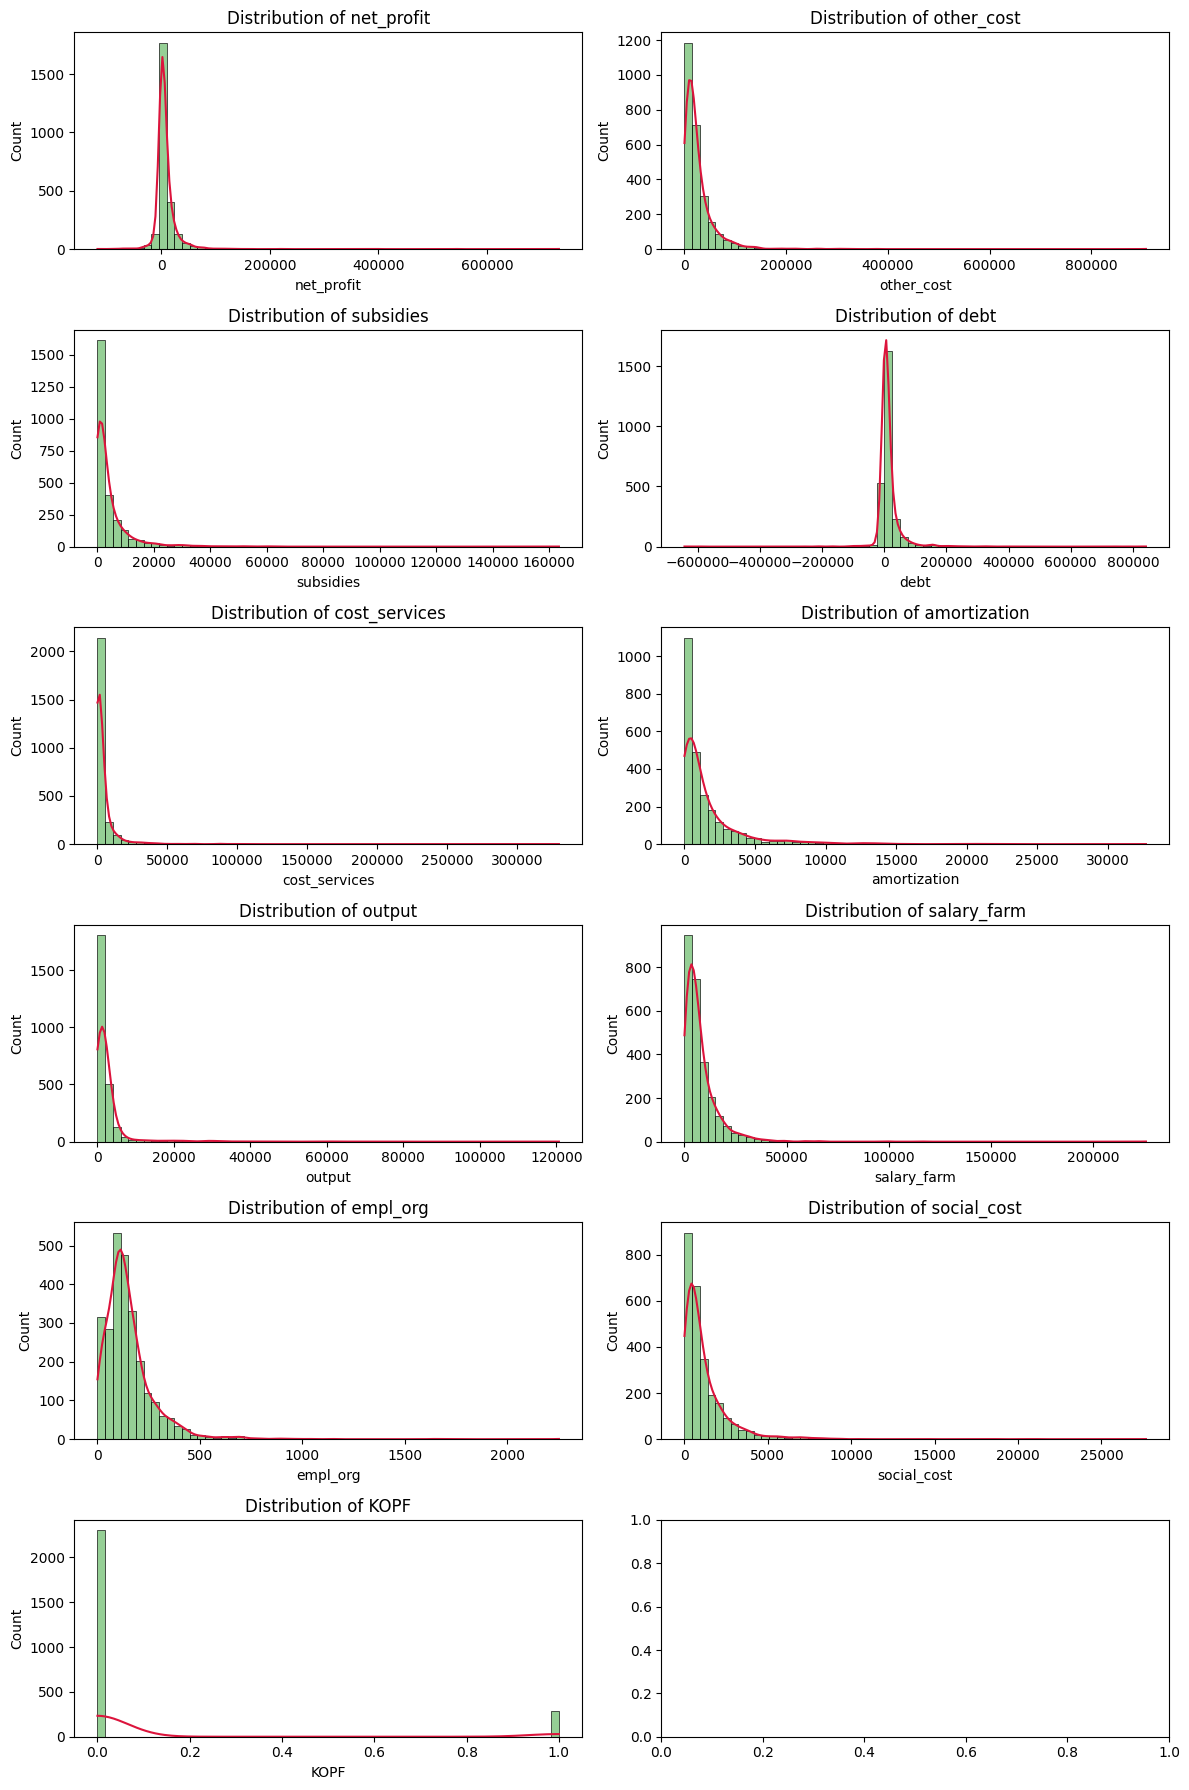

In [ ]:
feature_names = list(livestock.columns)
num_rows = 6
num_cols = 2
num_plots = len(feature_names)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 18), dpi=100)
axes = axes.flatten()

for i in range(num_plots):
    if i < num_plots:
        ax = axes[i]
        feature_data = livestock[feature_names[i]]
        b = sns.histplot(data=feature_data, bins=60, kde=True, color='tab:green', ax=ax)
        b.lines[0].set_color('crimson')
        ax.set_title(f'Distribution of {feature_names[i]}')

plt.tight_layout()
plt.show()


The above graphs show that the distribution of each observation is uneven and very different from the normal distribution. This was also evident from the descriptive statistics. Many observations are concentrated near low values, which indicates a large number of small enterprises in this industry and a very small number of large enterprises. At the same time, it can be seen that profits are concentrated in a small number of enterprises, i.e. large companies own most of the profits, creating more products.

Summing up the entire sample we can determine that the average enterprise receives subsidies in the amount of 4313 thousand rubles has costs in the form of debt burden (14084 thousand rubles), in the form of labor costs (7750 thousand rubles), in the form of social costs (1179 thousand rubles), in the form of depreciation (2849 thousand rubles), in the form of costs for work-services (4259 thousand rubles) and in the form of other costs (5980 thousand rubles) at the output of 2848 centners and the number of employees of 152 people.

In [8]:
# Create dummy
# agricultural organizations (KOPF= 47 52 54 55 65 67)
# peasant (farmer) farms and individual entrepreneurs (KOPF= 42).

livestock['dumm'] = 0
livestock.loc[livestock['KOPF'] == 42, 'dumm'] = 1
livestock = livestock.drop('KOPF', axis=1)
livestock = livestock.rename(columns={'dumm' : 'KOPF'})
livestock.head()

<ipython-input-8-655525110d4a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  livestock['dumm'] = 0


,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,social_cost,KOPF
0,8931.0,41323.0,3892.0,26477.0,13232.0,2114.0,2693.0,8735.0,294,1147,0
1,2495.0,19419.0,3710.0,11271.0,1719.0,582.0,1678.0,3827.0,166,490,0
2,98.0,24399.0,4096.0,18952.0,5407.0,572.0,3043.0,6790.0,235,1014,0
3,-4868.0,5718.0,207.0,10718.0,1254.0,162.0,668.0,1432.0,95,182,0
4,-3457.0,12246.0,825.0,3060.0,8019.0,0.0,332.0,1645.0,136,210,0


In [ ]:
livestock['KOPF'].value_counts()

0    2303
1     292
Name: KOPF, dtype: int64

In [9]:
df_org = livestock[(livestock['KOPF'] == 0 )]
df_farm = livestock[(livestock['KOPF'] == 1)]

In [ ]:
df_org.describe()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,social_cost,KOPF
count,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.0
mean,8709.976987,27555.095093,4386.471185,14692.085541,4252.829353,1741.746418,2938.557924,8158.130265,160.508033,1250.978723,0.0
std,28106.431861,36553.026130,8351.959843,51342.469733,11303.780023,2724.902490,7610.501379,9700.204032,129.112794,1628.634747,0.0
min,-117594.000000,0.000000,0.000000,-642913.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
25%,317.000000,9676.000000,638.000000,1097.000000,351.500000,278.000000,756.500000,3027.500000,92.000000,384.000000,0.0
50%,3538.000000,18085.000000,1917.000000,5448.000000,1210.000000,810.000000,1409.000000,5690.000000,131.000000,768.000000,0.0
75%,10739.500000,33195.000000,4852.000000,15799.500000,3638.000000,1992.000000,2456.500000,10283.500000,194.000000,1528.500000,0.0
max,732684.000000,907368.000000,163506.000000,842063.000000,197440.000000,32719.000000,120690.000000,225988.000000,2251.000000,27666.000000,0.0


In [ ]:
df_farm.describe()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,social_cost,KOPF
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.0
mean,992.530137,13557.746575,3735.460616,9288.256849,4309.441781,908.606164,2141.611986,4532.154110,87.222603,616.674658,1.0
std,11293.053105,20600.461853,8898.884230,28306.029454,23276.814285,1942.873653,7787.289822,6884.117668,108.135217,951.823679,0.0
min,-95858.000000,0.000000,0.000000,-213762.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0
25%,-214.500000,1473.750000,37.750000,441.500000,14.750000,19.000000,97.750000,540.750000,22.000000,72.000000,1.0
50%,143.000000,4911.500000,489.500000,2015.000000,440.500000,190.500000,372.000000,1759.000000,47.000000,214.500000,1.0
75%,1760.250000,15737.000000,2068.500000,9935.750000,1981.000000,858.000000,1133.250000,5295.000000,103.250000,699.250000,1.0
max,51825.000000,146174.000000,80269.000000,299388.000000,330164.000000,22051.000000,76733.000000,41489.000000,959.000000,6552.000000,1.0


**Analysis of descriptive sample statistics for 2 subgroups of farms.**

Net Profit:
        For df_org (KOPF=0), the mean net profit is much higher (approximately 8 710 000 rubles) compared to df_farm (KOPF=1), where the mean net profit is lower (approximately 993 000 rubles).

Other Costs:
        Organizations (df_org) have significantly higher average other costs (approximately 27 555 000 rubles) compared to farms (df_farm), where the average other costs are lower (approximately 13 558 000 rubles).

Subsidies:
        Organizations (df_org) receive higher subsidies on average (approximately 4 386 000 rubles) compared to farms (df_farm), which receive subsidies on average (approximately 3 735 000 rubles).

Debt:
        Organizations (df_org) have a higher average debt (approximately 14 692 000 rubles) compared to farms (df_farm), which have a lower average debt (approximately 9 288 000 rubles).

Cost of Services:
        The cost of services is higher for farms (df_farm) with an average of approximately 4 309 000 rubles, whereas organizations (df_org) have an average cost of services of approximately 4 253 000 rubles.

Amortization:
        Organizations (df_org) have a higher average amortization cost (approximately 1 742 000 rubles) compared to farms (df_farm), which have a lower average amortization cost (approximately 909 000 rubles).

Output:
        The output in terms of centners (e.g., production quantity) is not significantly higher for organizations (df_org) with an average of approximately 2 939 centners, while farms (df_farm) have an average output of approximately 2 142 centners.

Salary Costs:
        Organizations (df_org) incur higher average labor costs (approximately 8 158 000 rubles) compared to farms (df_farm) where the average labor costs are lower (approximately 4 532 000 rubles).

Number of Employees (empl_org):
        Organizations (df_org) have a higher average number of employees (approximately 161 employees) compared to farms (df_farm) with a lower average number of employees (approximately 87 employees).

Social Costs:
        Organizations (df_org) have higher social costs on average (approximately 1 251 000 rubles) compared to farms (df_farm) with lower social costs on average (approximately 617 000 rubles).

All these parameters indicate the importance of economies of scale in the agricultural industry. Large market players are eight times higher than farms in terms of profit, while average costs for all indicators (electricity, loan repayments, feed and veterinary costs, wages, social contributions, etc.) are only twice as high, and output is only 27% higher. And this suggests that large enterprises can set higher prices for their products, otherwise such a difference between profit and costs and output simply cannot be explained. At the same time, it can be seen that the gap between the most profitable companies and 75% of other companies is as huge for both organizations and small enterprises.

Interesting is the fact that the cost of sold goods, products, works, services in peasant (farm) households is even higher than in agricultural organizations. This most likely indicates that small enterprises have to resort to third-party services of other organizations more often, which in general increases their costs.

As for subsidies, the situation is approximately equal. Organizations are only 14.8% higher than small farms in subsidies received in the sphere of livestock breeding.  

**The basic linear performance model (model A) can be formulated as follows:**

    Y=β0+β1⋅X1+β2⋅X2+ ... X_n⋅B_n +ϵ

where:

    Y - is the dependent variable (e.g.,  net_profit).
    β0​ - is the intercept.
    β1​ до β_n​ - are the regression coefficients for the respective independent variables.
    X1​ до X_n​ - are the independent variables (other_cost, social_cost, subsidies, debt, cost_services, amortization, output, salary_farm, empl_org).
    ϵ - represents the error term.

**To estimate a linear regression model, it's necessary to meet the following model assumptions as per the Classical Linear Regression Model (CLRM):**

    Zero Mean of Errors: The expected value of the errors (ϵ) is equal to zero: E(ϵ)=0. This assumption implies that the errors have an average value of zero.

    Independence of Errors from Explanatory Variables: The errors (ϵ) are independent of all explanatory variables. Violation of this condition can lead to systematic bias.

    Homoscedasticity: The variance of errors is constant for all observations, which can be expressed as Var(ϵ)=σ2. This means that the variability of errors remains the same across the range of the independent variables.

    No Autocorrelation: There is no systematic relationship between the errors for any two observations. Autocorrelation occurs when errors are correlated with each other over time or across observations.

These conditions are essential in linear regression and are part of the Gauss-Markov theorem, which states that the Ordinary Least Squares (OLS) estimates are the Best Linear Unbiased Estimators (BLUE) of the model parameters when these conditions are met. Additionally, it is assumed that the errors (ϵϵ) follow a normal distribution with zero mean and constant variance, which is important for hypothesis testing and confidence intervals. Failure to meet these conditions may require model adjustments or consideration of alternative analysis methods.

In [10]:
y = livestock['net_profit']
X = livestock.drop('net_profit', axis=1)

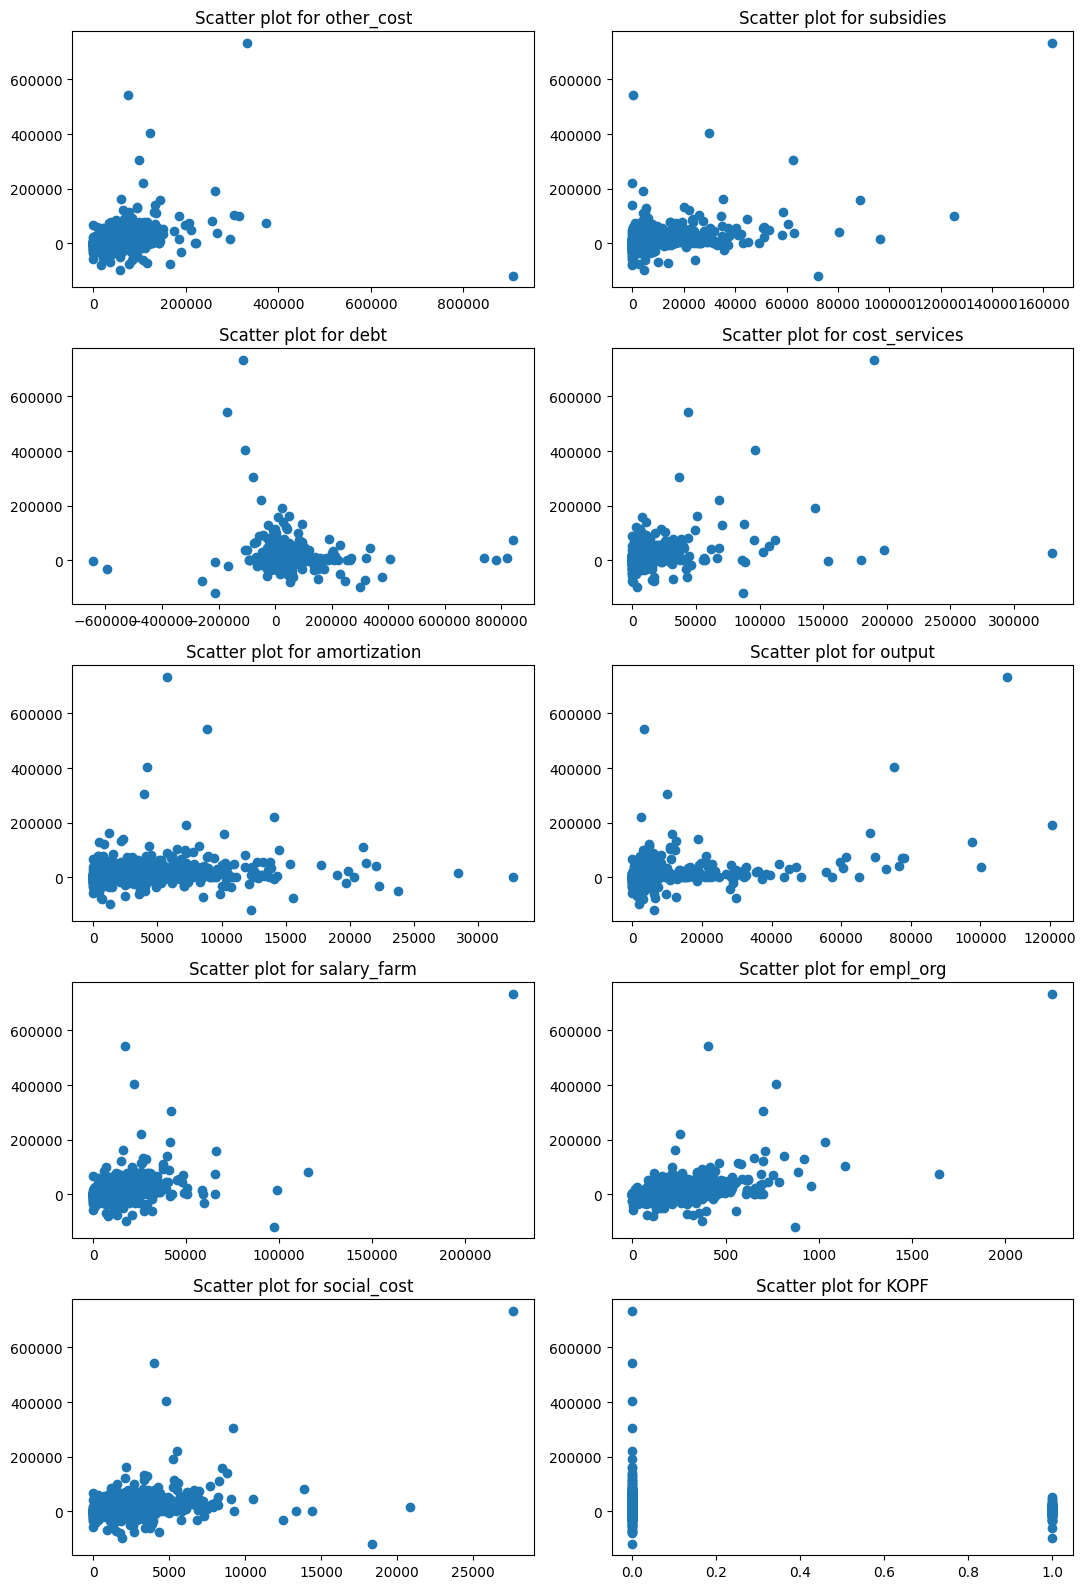

In [ ]:
feature_names = list(X.columns)
num_rows = 5
num_plots = len(feature_names)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(11, 16), dpi=100)
axes = axes.flatten()

for i in range(num_plots):
  if i < num_plots:
    ax = axes[i]
    feature_data = X[feature_names[i]]
    ax.scatter(x=feature_data, y=y, marker='o')
    ax.set_title(f'Scatter plot for {feature_names[i]}')
  else:
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

The graphs show that there is some dependence of most of the cost indicators except for depreciation. The dependence of subsidies, output and number of employees can also be traced, although the situation is not so obvious for the output indicator.

As for the difference between accounts payable and accounts receivable, the situation is ambiguous. On the one hand, there is an increase in the net profit indicator with a decrease in the debt burden. On the other hand, there are companies with large accounts receivable (i.e. these companies owe other companies), but low net profit indicators. Most likely, this indicator should be analyzed taking into account the time factor to better understand how it affects profit.


In [11]:
X_A = X.drop('KOPF', axis=1)
X_A = sm.add_constant(X_A)
model_A = sm.OLS(y, X_A)
results_A = model_A.fit()
print(results_A.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     227.6
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          1.11e-319
Time:                        07:18:47   Log-Likelihood:                -29389.
No. Observations:                2595   AIC:                         5.880e+04
Df Residuals:                    2585   BIC:                         5.886e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6473.3196    633.725    -10.215

**Statistical properties of the resulting model**

R-squared (R²): The R-squared value indicates how well the model explains the variation in the dependent variable. In this case, R² is equal to 0.442, which means the model explains approximately 44.2% of the variation in net_profit. This can be considered a moderate level of explained variation.

F-statistic: The F-statistic is used to test the overall significance of the model. In this instance, the F-statistic is 227.6, and the p-value (Prob (F-statistic)) is very close to zero (1.11e-319), indicating that the model is statistically significant as a whole.

P-values (P>|t|): P-values assess the statistical significance of each coefficient. It's important to pay attention to p-values. For example, the p-value for other_cost is 0.000, which signifies the statistical significance of this variable. However, amortization and social_cost have high p-values, suggesting their lack of significance in the model

Omnibus: The Omnibus test provides a measure of the normality of the residuals (errors). In this case, a high Omnibus value, such as 3642.815, indicates that the residuals may not be normally distributed.

Durbin-Watson: The Durbin-Watson statistic checks for autocorrelation, which is the dependence of errors on each other. The value of 1.885 suggests a value close to 2, which is good as it indicates little to no autocorrelation.

Jarque-Bera: The Jarque-Bera test is another test for normality. A high Jarque-Bera statistic, as in this case (3114195.664), indicates that the residuals do not follow a normal distribution.

Skew: Skew measures the symmetry of the residual distribution. A skew value of 7.598 suggests significant positive skewness in the distribution of residuals.

Kurtosis: Kurtosis measures the tailedness of the residual distribution. A high kurtosis value (172.029) indicates heavy tails in the distribution, which means the residuals have more extreme values.

Condition Number: The condition number assesses the presence of multicollinearity, which occurs when independent variables are highly correlated with each other. A large condition number, such as 9.06e+04, suggests potential multicollinearity or numerical issues in the model.


**Interpretation of results.**

other_cost: The coefficient is -0.2514. This means that an increase in expenses on other costs (other_cost) by one unit results in a decrease in profit (net_profit) by 0.2514 thousand rubles, assuming all other factors remain constant.

subsidies: The coefficient is 0.6926. An increase in subsidies by one unit leads to an increase in profit (net_profit) by 0.6926 thousand rubles, while keeping all other factors constant.

debt: The coefficient is -0.0975. An increase in debts (debt) by one unit reduces profit (net_profit) by 0.0975 thousand rubles, assuming all other factors remain constant.

cost_services: The coefficient is 0.3801. Increasing expenses on services (cost_services) by one unit increases profit (net_profit) by 0.3801 thousand rubles, with all other factors held constant.

amortization: The coefficient is 0.0321. This coefficient is not statistically significant, and its influence on profit is not representative.

output: The coefficient is 0.4368. An increase in output by one unit raises profit (net_profit) by 0.4368 thousand rubles, assuming all other factors remain constant.

salary_farm: The coefficient is 0.7215. An increase in labor costs (salary_farm) by one unit increases profit (net_profit) by 0.7215 thousand rubles, while keeping all other factors constant.

empl_org: The coefficient is 67.4664. An increase in the average annual number of employees (empl_org) by one person raises profit (net_profit) by 67.4664 thousand rubles, with all other factors held constant.

social_cost: The coefficient is 0.3843. This coefficient is also not statistically significant and does not have a significant impact on profit.

In [ ]:
# Outliers and leverage points

import statsmodels.stats.outliers_influence as oi

residuals = results_A.resid

leverage = oi.OLSInfluence(results_A).influence

cooks_distance, _ = oi.OLSInfluence(results_A).cooks_distance

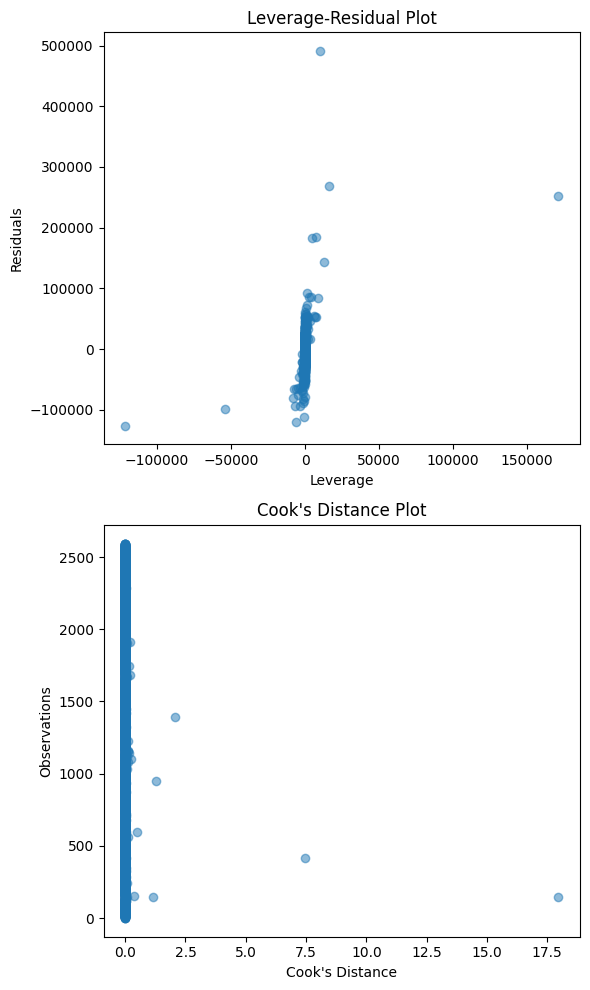

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10))
ax[0].scatter(leverage, residuals, alpha=0.5)
ax[0].set_title('Leverage-Residual Plot')
ax[0].set_xlabel('Leverage')
ax[0].set_ylabel('Residuals')

ax[1].scatter(cooks_distance, range(len(cooks_distance)), alpha=0.5)
ax[1].set_title("Cook's Distance Plot")
ax[1].set_xlabel("Cook's Distance")
ax[1].set_ylabel('Observations')

plt.tight_layout()
plt.show()

We see several imbalance points. Points with very low leverage values (-125000 and -50000) can be suspicious and are potential points of unbalance, especially if their residuals are very different from the average level. A point with a very high leverage value (around 175000) is also a potential point of unbalance. A point with residuals around 490000 is also very different from the average residuals and can be a potential point of unbalance. Points with residuals between 100000 and 200000, as well as a point with a residual around 260000, can also be suspicious and potentially considered as an unbalance point.

We will can try to compare impalance points and outliers points and then remove them.

In [ ]:
threshold=1
outliers_count = sum(cooks_distance > threshold)

print(f"Number of outliers of Cook's Distance > {threshold}: {outliers_count}")

Number of outliers of Cook's Distance > 1: 5


In [ ]:
outliers_indices = [
    i for i, distance in enumerate(cooks_distance) if distance > threshold
    ]
outliers = X_A.iloc[outliers_indices]
print(outliers)

      const  other_cost  subsidies      debt  cost_services  amortization  \
143     1.0    331030.0   163506.0 -115219.0       189775.0        5742.0   
148     1.0    123317.0    29623.0 -107777.0        95987.0        4190.0   
418     1.0    907368.0    72062.0 -211232.0        86945.0       12300.0   
950     1.0     75543.0      274.0 -171063.0        43938.0        8827.0   
1395    1.0     15526.0     2851.0   63514.0       330164.0          82.0   

        output  salary_farm  empl_org  social_cost  
143   107662.0     225988.0      2251        27666  
148    75159.0      21758.0       770         4809  
418     6225.0      97108.0       874        18393  
950     3423.0      16968.0       407         3987  
1395    1582.0       1899.0       180          370  


In [ ]:
livestock.describe()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,social_cost,KOPF
count,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000
mean,7841.578343,25980.056262,4313.216817,14084.024663,4259.199615,1647.998073,2848.882312,7750.120617,152.261657,1179.604239,0.112524
std,26857.090812,35396.334481,8416.003095,49316.495885,13197.489220,2661.216427,7633.231854,9493.783825,129.003540,1579.778162,0.316071
min,-117594.000000,0.000000,0.000000,-642913.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,134.500000,7952.500000,510.500000,916.000000,290.000000,224.000000,629.000000,2532.000000,81.000000,323.000000,0.000000
50%,2889.000000,16692.000000,1669.000000,5085.000000,1123.000000,742.000000,1292.000000,5323.000000,125.000000,710.000000,0.000000
75%,9903.000000,31897.000000,4685.000000,15042.000000,3432.000000,1900.000000,2368.000000,9783.000000,189.500000,1476.000000,0.000000
max,732684.000000,907368.000000,163506.000000,842063.000000,330164.000000,32719.000000,120690.000000,225988.000000,2251.000000,27666.000000,1.000000


In [ ]:
threshold_leverage = 50000
threshold_residuals = 100000
imbalanced_indices = [
    i for i, (leverage_val, residual_val) in enumerate(zip(leverage, residuals))
    if abs(leverage_val) > threshold_leverage or abs(residual_val) > threshold_residuals
    ]
imbalanced_points = X_A.iloc[imbalanced_indices]
print(imbalanced_points)

      const  other_cost  subsidies      debt  cost_services  amortization  \
143     1.0    331030.0   163506.0 -115219.0       189775.0        5742.0   
148     1.0    123317.0    29623.0 -107777.0        95987.0        4190.0   
150     1.0     98774.0    62340.0  -79035.0        36681.0        3913.0   
418     1.0    907368.0    72062.0 -211232.0        86945.0       12300.0   
598     1.0    315881.0    34483.0   82568.0        17332.0       14460.0   
950     1.0     75543.0      274.0 -171063.0        43938.0        8827.0   
1099    1.0    107941.0        0.0  -51585.0        67760.0       14079.0   
1395    1.0     15526.0     2851.0   63514.0       330164.0          82.0   
1680    1.0     84510.0    24307.0   62922.0        42725.0        3581.0   
1683    1.0    146174.0    41100.0   -4052.0       102739.0        3335.0   

        output  salary_farm  empl_org  social_cost  
143   107662.0     225988.0      2251        27666  
148    75159.0      21758.0       770         

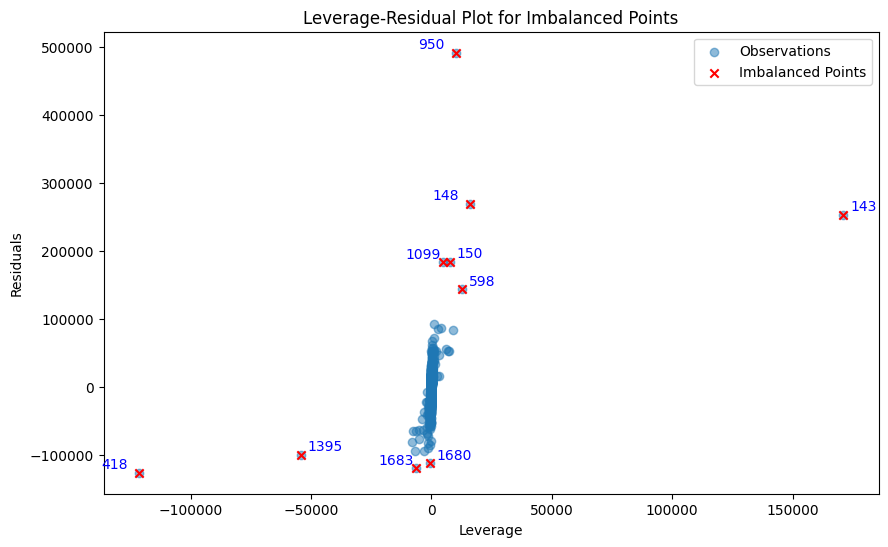

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(leverage, residuals, alpha=0.5, label="Observations")
ax.scatter(leverage[imbalanced_indices], residuals[imbalanced_indices], c='red',
           marker='x', label="Imbalanced Points")
sorted_imbalanced_indices = sorted(imbalanced_indices, key=lambda i: leverage[i])
start_right = False
index_color = 'blue'
for i in sorted_imbalanced_indices:
    if start_right:
        ax.annotate(str(i), (leverage[i], residuals[i]), xytext=(5, 3),
                    textcoords='offset points', color=index_color)
    else:
        ax.annotate(str(i), (leverage[i], residuals[i]), xytext=(-27, 3),
                    textcoords='offset points', color=index_color)
    start_right = not start_right
ax.set_title("Leverage-Residual Plot for Imbalanced Points")
ax.set_xlabel("Leverage")
ax.set_ylabel("Residuals")
ax.legend()
plt.show()

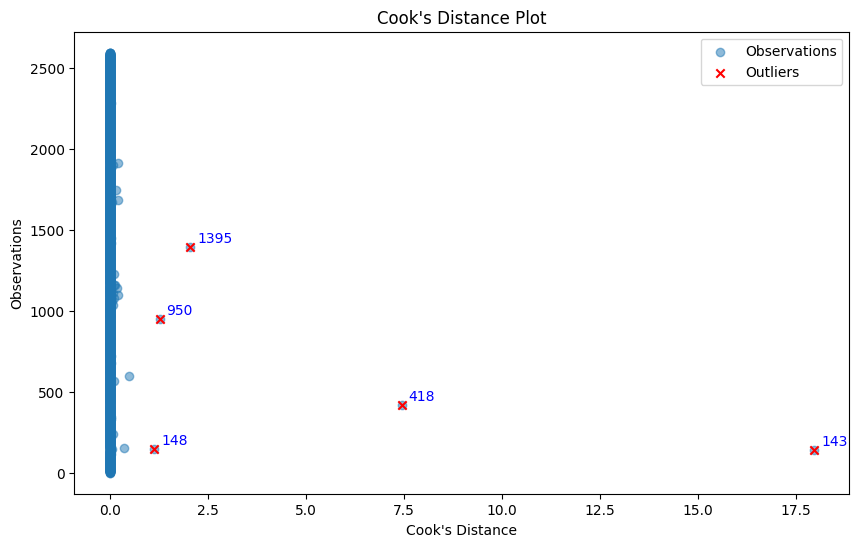

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(cooks_distance, range(len(cooks_distance)), alpha=0.5, label="Observations")
ax.scatter(cooks_distance[outliers_indices], outliers_indices, c='red', marker='x', label="Outliers")
sorted_outliers_indices = sorted(outliers_indices, key=lambda i: cooks_distance[i])
for i in sorted_outliers_indices:
    ax.annotate(str(i), (cooks_distance[i], i), xytext=(5, 3),
                    textcoords='offset points', color='blue')
ax.set_title("Cook's Distance Plot")
ax.set_xlabel("Cook's Distance")
ax.set_ylabel("Observations")
ax.legend()
plt.show()

All cook's outlier points are disbalance. And it's good signal to remove them and check how indicators of our model change.

In [ ]:
X_A_without_outliers = X_A.drop(outliers_indices)
y_without_outliers = y.drop(outliers_indices)
X_A_without_outliers.shape, X_A.shape

((2590, 10), (2595, 10))

In [ ]:
X_A_without_outliers = sm.add_constant(X_A_without_outliers)
model_A_without_outliers = sm.OLS(y_without_outliers, X_A_without_outliers)
results_without_outliers = model_A_without_outliers.fit()
print(results_without_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     167.8
Date:                Thu, 16 Nov 2023   Prob (F-statistic):          1.39e-250
Time:                        16:47:39   Log-Likelihood:                -28529.
No. Observations:                2590   AIC:                         5.708e+04
Df Residuals:                    2580   BIC:                         5.714e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3861.0728    473.704     -8.151

The regression analysis data showed a clear deterioration of the model after removing outliers. This can be seen from the reduction of R2 by almost 0.1 point and the increase in the number of insignificant observations. In the first case there were 2 insignificant coefficients, after removing outliers there were 4 at 5% significance level. Yes, the normality of the distribution has improved, but in this case it is still very different from normal.

Removing only the most extreme outliers under the index numbers 418 and 143 shown in the outlier plot made things even worse. It would be better to look at the summary of livestock data to see which outliers stick out the most.

After comparison, it becomes clear that two observations are most strongly outliers from the general group. These are observations numbered 418 and 1395. Observation 418 has too high costs with not so significant output. And observation 1395 has too low depreciation and very low wages (10000 rubles). Let's try to remove them and see what it will be about.

In [ ]:
X_A_without_outliers = X_A.drop([418, 1395])
y_without_outliers = y.drop([418, 1395])
X_A_without_outliers.shape, X_A.shape

((2593, 10), (2595, 10))

In [ ]:
X_A_without_outliers = sm.add_constant(X_A_without_outliers)
model_A_without_outliers = sm.OLS(y_without_outliers, X_A_without_outliers)
results_without_outliers = model_A_without_outliers.fit()
print(results_without_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     246.7
Date:                Thu, 16 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:47:48   Log-Likelihood:                -29308.
No. Observations:                2593   AIC:                         5.864e+04
Df Residuals:                    2583   BIC:                         5.870e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6232.0380    622.533    -10.011

Alternately removing one or the other observation resulted in comparatively better descriptive statistics after removing both outliers. Amortization became significant at 5% significance level, F-statistic increased, p-value went to zero, R2 increased slightly.

In [ ]:
from scipy.stats import f
from sklearn.linear_model import LinearRegression

class ChowTest:
    def __init__(self, X, y, last_index_in_model_1, first_index_in_model_2):
        self.X = X
        self.y = y
        self.last_index_in_model_1 = last_index_in_model_1
        self.first_index_in_model_2 = first_index_in_model_2

    def f_value(self):
        def find_rss(y, X):
            model = sm.OLS(y, sm.add_constant(X)).fit()
            rss = model.ssr
            length = len(y)
            return rss, length

        y_total = self.y
        X_total = self.X
        y1 = y_total[: self.last_index_in_model_1 + 1]
        X1 = X_total[: self.last_index_in_model_1 + 1]
        y2 = y_total[self.first_index_in_model_2 :]
        X2 = X_total[self.first_index_in_model_2 :]

        rss_total, n_total = find_rss(y_total, X_total)
        rss1, n_1 = find_rss(y1, X1)
        rss2, n_2 = find_rss(y2, X2)

        k = X_total.shape[1] + 1
        numerator = (rss_total - (rss1 + rss2)) / k
        denominator = (rss1 + rss2) / (n_1 + n_2 - 2 * k)

        return numerator / denominator

    def p_value(self):
        F = self.f_value()
        if not F:
            return 1
        df1 = 2
        df2 = len(self.X) + self.first_index_in_model_2 - self.last_index_in_model_1 - 2

        p_val = f.sf(F, df1, df2)
        return p_val

    def run_test(self):
        Chow_Stat = self.f_value()
        p_value = self.p_value()
        return Chow_Stat, p_value

In [12]:
livestock = livestock.drop([418, 1395])
livestock = livestock.reset_index(drop=True)
livestock_sort = livestock.sort_values('KOPF')
livestock_sort = livestock_sort.reset_index(drop=True)

In [ ]:
X_exp = livestock_sort.drop(['net_profit', 'KOPF'], axis=1)
y_exp = livestock_sort['net_profit']
last_index_in_model_1 = 2301
first_index_in_model_2 = 2302
significance_level = 0.05

chow_test = ChowTest(X_exp, y_exp, last_index_in_model_1, first_index_in_model_2)
result = chow_test.run_test()
print("Chow Statistic:", result[0])
print("P-value:", result[1])

Chow Statistic: 23.34183630631757
P-value: 8.973811869538257e-11


In [ ]:
!git clone https://github.com/SergeyHSE/ChowTest.git

%cd ChowTest

!pip install .

Cloning into 'ChowTest'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 27 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (27/27), 8.48 KiB | 2.83 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/ChowTest
Processing /content/ChowTest
  Preparing metadata (setup.py) ... done
  Created wheel for ChowTest: filename=ChowTest-0.1-py3-none-any.whl size=2718 sha256=0e09dd2164292c8127cc92cfd71012023a3c3e3528e0b22297f2934d73100047
  Stored in directory: /tmp/pip-ephem-wheel-cache-2muaz3ot/wheels/41/e6/67/35d51a7dd057e74c33c09ccf1f4ad9c5e2961edfce95a7c787
Successfully built ChowTest


In [ ]:
from ChowTest import chowtest

In [ ]:
chow_result = chowtest(X_exp, y_exp, last_index_in_model_1, first_index_in_model_2, significance_level)
Chow_Stat, p_value = chow_result

print("Chow Statistic:", Chow_Stat)
print("P-value:", p_value)

****************************************************************************************************
Reject the null hypothesis of equality of regression coefficients in the 2 periods.
****************************************************************************************************
Chow Statistic: 23.34183630631761 p value: 0.0
****************************************************************************************************
Chow Statistic: 23.34183630631761
P-value: 1.1102230246251565e-16


Chow test show that we should estimate two groups separately, because p-value is very signifivant.

In [ ]:
from statsmodels.stats.diagnostic import linear_reset

X = livestock.drop(['net_profit', 'KOPF'], axis=1)
y = livestock['net_profit']
X = sm.add_constant(X)
model_reset = sm.OLS(y, X).fit()
results_reset = linear_reset(model_reset, power=2, test_type='fitted', use_f=True)
print(results_reset.summary())

<F test: F=400.1356192083161, p=7.106319449754319e-83, df_denom=2.58e+03, df_num=1>


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/diagnostic.py:1065: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


This means that we need to We reject the null hypothesis. This means that we have statistically significant evidence that the model is incorrectly specified, and possibly contains missing variables.

In [ ]:
X = livestock.drop(['net_profit'], axis=1)
y = livestock['net_profit']
X = sm.add_constant(X)
model_reset = sm.OLS(y, X).fit()
results_reset = linear_reset(model_reset, power=2, test_type='fitted', use_f=True)
print(results_reset.summary())

<F test: F=405.98522104774446, p=5.6551107459347595e-84, df_denom=2.58e+03, df_num=1>


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/diagnostic.py:1065: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


When the KOPF variable is included in our Dummy model, the results of the model evaluation have not changed, and the variable itself and its coefficient turn out to be insignificant.

In [17]:
X = livestock.drop(['net_profit'], axis=1)
y = livestock['net_profit']
X = sm.add_constant(X)
model_dummy = sm.OLS(y, X)
results_dummy = model_dummy.fit()
print(results_dummy.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     223.0
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        08:13:35   Log-Likelihood:                -29306.
No. Observations:                2593   AIC:                         5.863e+04
Df Residuals:                    2582   BIC:                         5.870e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5650.3967    668.778     -8.449

We see that there are no any improvments in values of our summary compared to the previous model without dummy. But dummy variable is significant.

In [ ]:
# F-test (Wald)
X_notdummy = livestock.drop(['net_profit', 'KOPF'], axis=1)
y = livestock['net_profit']
X_notdummy = sm.add_constant(X_notdummy)
model_notdummy = sm.OLS(y, X_notdummy).fit()
model_dummy = sm.OLS(y, X).fit()
f_test = model_dummy.compare_f_test(model_notdummy)

print(f_test)

(5.60059620766236, 0.018027777878205187, 1.0)


The results (5.60059620766236, 0.018027777878205187, 1.0) represent the F-test output, where:

F-statistic: This is the value of the test statistic. In our case, it is 5.60059620766236.

p-value: This is the probability of obtaining the observed F-statistic or more extreme, assuming the null hypothesis is true (typically stating that adding the additional variable does not improve the model). Our p-value is 0.018027777878205187.

df_diff (degrees of freedom difference): This is the difference in degrees of freedom between the models with and without the additional variable. In our case, it is 1.0.

Thus, the test results suggest that adding the extra variable improves the model, as the p-value (0.018) is less than the standard significance level of 0.05.

In [ ]:
# Logarifm taking into account negative values
def logtransform(x):
  if x == 0:
    return 0
  if x > 0:
    return np.log(x)
  if x < 0:
    return np.log(-x) * (-1)

In [13]:
# Logarifm
def logtransform(x):
  if x <= 0:
    return 0
  elif x > 0:
    return np.log(x)

In [14]:
livestock_log = livestock.applymap(logtransform)
livestock_log = livestock_log.drop('KOPF', axis=1)
livestock_log = pd.concat([livestock_log, livestock['KOPF']], axis=1)
livestock_log.head()

,net_profit,other_cost,subsidies,debt,cost_services,amortization,output,salary_farm,empl_org,social_cost,KOPF
0,9.097284,10.629175,8.266678,10.184032,9.490393,7.656337,7.898411,9.075093,5.683580,7.044905,0
1,7.822044,9.874007,8.218787,9.329988,7.449498,6.366470,7.425358,8.249836,5.111988,6.194405,0
2,4.584967,10.102297,8.317766,9.849665,8.595450,6.349139,8.020599,8.823206,5.459586,6.921658,0
3,0.000000,8.651374,5.332719,9.279680,7.134094,5.087596,6.504288,7.266827,4.553877,5.204007,0
4,0.000000,9.412955,6.715383,8.026170,8.989569,0.000000,5.805135,7.405496,4.912655,5.347108,0


In [28]:
X_log = livestock_log.drop('net_profit', axis=1)
y_log = livestock_log['net_profit']
X_log = sm.add_constant(X_log)
model_log = sm.OLS(y_log, X_log)
results_log = model_log.fit()
print(results_log.summary())

                            OLS Regression Results                            
Dep. Variable:             net_profit   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     123.9
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          2.11e-211
Time:                        08:46:18   Log-Likelihood:                -6502.8
No. Observations:                2593   AIC:                         1.303e+04
Df Residuals:                    2582   BIC:                         1.309e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5685      0.344     -1.654

## Meaningful interpretation of the logarithmic model

We applied logarithm to all variables and got a sharp deterioration of the model. At the same time, if we log the profit separately, then R2 falls even more. A poor explanation of the model can also be seen in the figure below.

The coefficient for other_cost is not statistically significant (p-value > 0.05), indicating that changes in other_cost do not have a statistically significant impact on net_profit (logarithm).

For subsidies, a 1% increase is associated with an expected increase in net_profit (logarithm) of 0.2536, suggesting a positive relationship between the level of subsidies and the logarithm of profit.

An increase of 1% in debt is associated with an expected decrease in net_profit (logarithm) of 0.1578, indicating a negative relationship between debt levels and the logarithm of profit.

For cost_services, a 1% increase is associated with an expected increase in net_profit (logarithm) of 0.0789, indicating a positive relationship between service costs and the logarithm of profit.

The coefficient for amortization is not statistically significant (p-value > 0.05), suggesting that changes in amortization do not have a statistically significant impact on net_profit (logarithm).

The coefficient for output is not statistically significant (p-value > 0.05), suggesting that changes in output do not have a statistically significant impact on net_profit (logarithm).

The coefficient for salary_farm is not statistically significant (p-value > 0.05), suggesting that changes in salary_farm do not have a statistically significant impact on net_profit (logarithm).

A 1% increase in the average number of employees (empl_org) is associated with an expected increase in net_profit (logarithm) of 1.2199, indicating a strong positive relationship between the number of employees and the logarithm of profit.

The coefficient for social_cost is not statistically significant (p-value > 0.05), suggesting that changes in social_cost do not have a statistically significant impact on net_profit (logarithm).


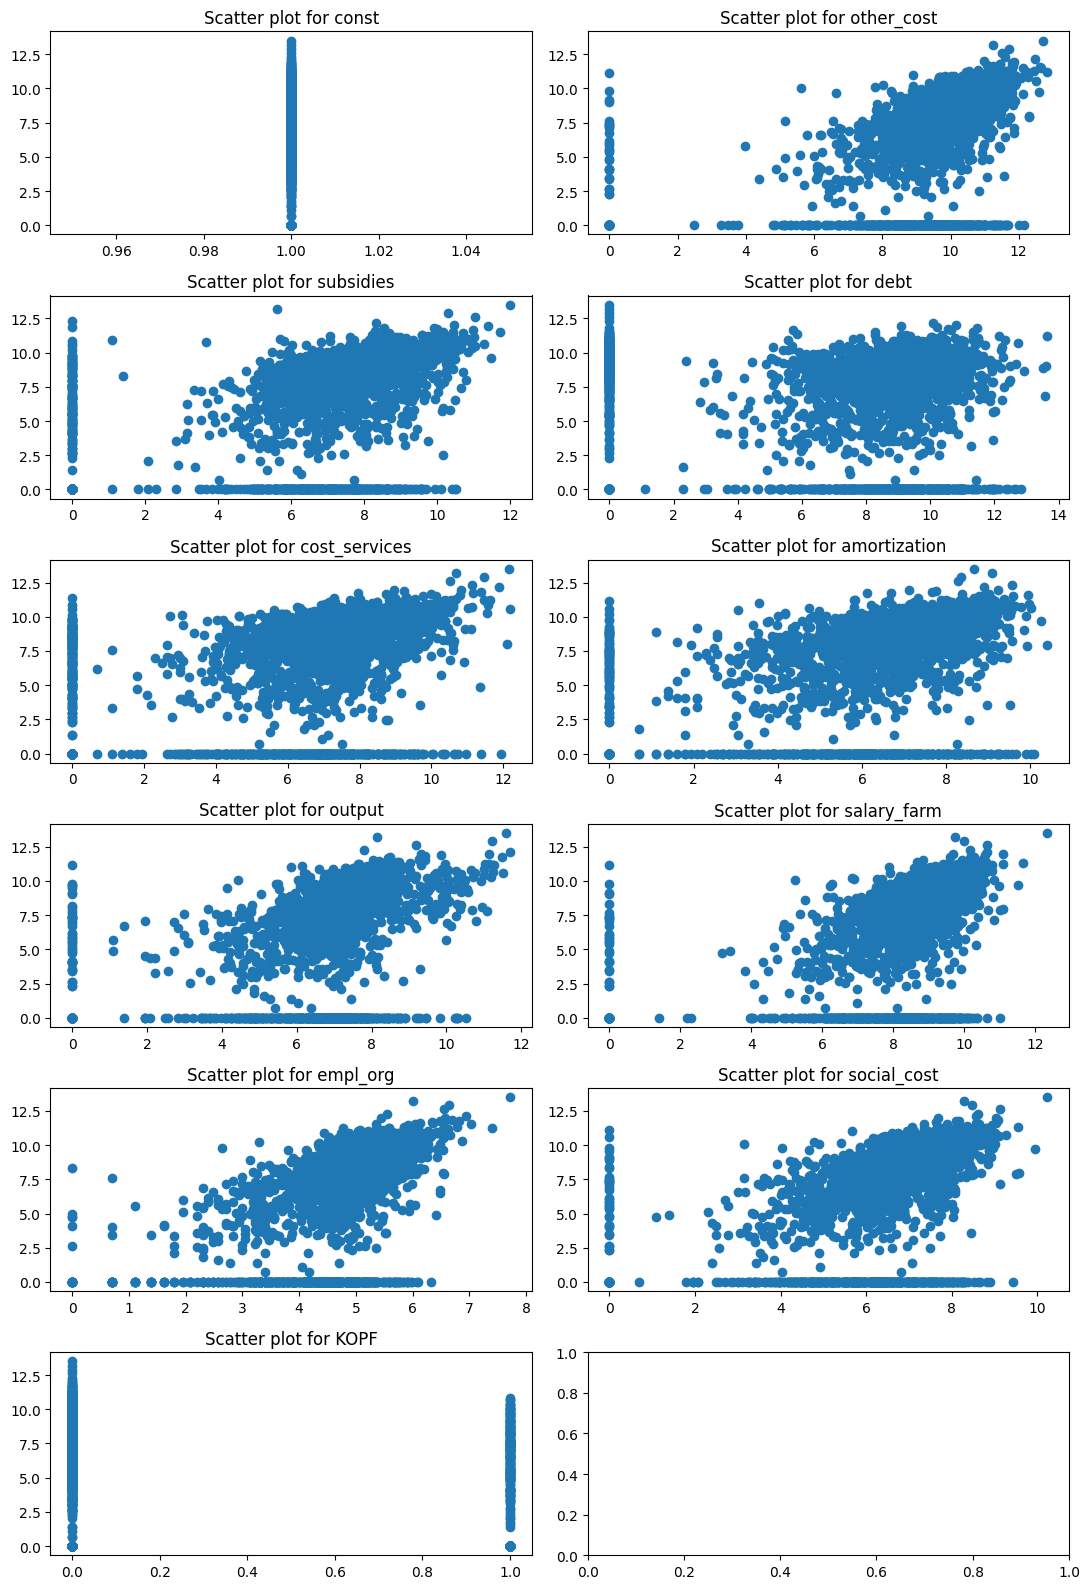

In [16]:
feature_names = list(X_log.columns)
num_rows = 6
num_plots = len(feature_names)
num_cols = 2
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(11, 16), dpi=100)
axes = axes.flatten()

for i in range(num_plots):
  if i < num_plots:
    ax = axes[i]
    feature_data = X_log[feature_names[i]]
    ax.scatter(x=feature_data, y=y_log, marker='o')
    ax.set_title(f'Scatter plot for {feature_names[i]}')
  else:
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

In [33]:
# Получение значений AIC и BIC для обеих моделей
aic_log = results_log.aic
bic_log = results_log.bic

aic_dummy = results_dummy.aic
bic_dummy = results_dummy.bic

# Вывод результатов
print("AIC (Log):", aic_log)
print("BIC (Log):", bic_log)
print("AIC (Linear):", aic_dummy)
print("BIC (Linear):", bic_dummy)

AIC (Log): 13027.585503481994
BIC (Log): 13092.051782122919
AIC (Linear): 58633.2559846775
BIC (Linear): 58697.72226331842


In [39]:
from statsmodels.stats.stattools import jarque_bera

residuals_log = results_log.resid
residuals_dummy = results_dummy.resid

# Jarque-Bera test
jb_log, p_value_log, _, _ = jarque_bera(residuals_log)
jb_dummy, p_value_dummy, _, _ = jarque_bera(residuals_dummy)

# Вывод результатов
print('Jarque-Bera test for log model:')
print('JB statistic:', jb_log)
print('P-value:', p_value_log)

print('\nJarque-Bera test for linear model:')
print('JB statistic:', jb_dummy)
print('P-value:', p_value_dummy)

Jarque-Bera test for log model:
JB statistic: 703.0983793925122
P-value: 2.1092438784787087e-153

Jarque-Bera test for linear model:
JB statistic: 3263626.6825475637
P-value: 0.0
